# Chess Analysis with Stockfish

I play way too much chess, but honestly, I'm terrible. Thinking about the games I've played recently, I would say I do pretty well up until somewhere around the tenth move, then things start to break down. But can I can get a better sense of when I begin to fall apart? Would I be a better player if I could keep it together longer?

## Hypothesis

If I am able to make my first blunder or mistake later in the game, I can become a better chess player. In theory, if my opponent makes the first mistake and I'm able to capatilize on it, then I should win.

### Resources

[Stockfish](https://stockfishchess.org/) is an open source chess engine that can recommend the best moves, identify mistakes, and more. I'll be using this engine to analyze all of the games on my [chess.com](https://www.chess.com/) profile.

## Get the Data

The code below will load games in Portable Game Notation (PGN) from Chess.com. Change the value of the variable user to analyze a different person.


In [1]:
from stockfish import Stockfish
import numpy as np
import pandas as pd
import chess
import chess.pgn
import datetime
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import io
import importlib
from get_data import *
#from run_engine import *
import run_engine

In [2]:
# load all of the chess data for a given user
user = 'settty'
games = get_chess_data(user)

In [3]:
# look at basic description of df
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37493 entries, 0 to 37492
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_link           37493 non-null  object        
 1   game_date           37493 non-null  datetime64[ns]
 2   white               37493 non-null  object        
 3   black               37493 non-null  object        
 4   result              37493 non-null  object        
 5   opening             37493 non-null  object        
 6   winner              37493 non-null  object        
 7   user_color          37493 non-null  object        
 8   winner_count        37493 non-null  object        
 9   end_time            37493 non-null  object        
 10  time_control        37493 non-null  object        
 11  white_elo           37493 non-null  object        
 12  black_elo           37493 non-null  object        
 13  moves               37493 non-null  object    

In [4]:
# see how many games user has won, lost, and drawn
games.groupby('game_link').first().winner_count.value_counts()

settty    367
other     319
draw       25
Name: winner_count, dtype: int64

In [5]:
# the data is faster to load from a csv, though with the number of games I have, it's not too slow. But there should be a check
# when I get the api working where it looks at the last game in the csv and then gets any games more recent than that and
# applies the above loading and cleaning. Will come later
#hdr = False  if os.path.isfile('data/loaded_games.csv') else True
#loaded_games.to_csv("data/loaded_games.csv", mode = 'a', index = False, header = hdr)

### Run the Chess Engine

Ok now that we have the data loaded, let's start to run the Stockfish chess engine on games, move by move. This process takes a lot of processing power, so be patient while it analyzes every move. It took just over 3 hours hours to process about 700 games.

The chess engine will output an analysis of the board in a unit know as [centipawns](https://en.wiktionary.org/wiki/centipawn#:~:text=Noun,calculation%20purposes%20in%20computer%20chess). A centipawn represents the value of a single pawn. In other words, if you are up 100 centipawns, you are up a single pawn (though it's more complicated than that).

One key thing to remember is that when playing as white, a positive centipawn value means white holds a lead, while a negative centipawn value means black holds a lead.

In [ ]:
# load any saved games and run the engine on new games
saved_games = "data/scored_games.csv"
scored_games = run_engine.load_scores(saved_games, games)

# save new scored games
scored_games.to_csv('data/scored_games.csv', index = False)

 90%|█████████ | 598/664 [02:54<00:17,  3.69it/s]

In [ ]:
scored_games.head()

In [22]:
scored_games.to_csv('data/scored_games.csv', index = False)

In [ ]:
if os.path.isfile('data/scored_games.csv'):
    scored_games = pd.read_csv('data/scored_games.csv')
#elif os.path.isfile('data/scored_games.csv') & scored_games['game_date'].max() < loaded_games['game_date'].max():
    #work on this code later
    #print("There are newer games to be scored")
else:
    rows = []
    # this computation is slow as the engine needs to evaluate each move
    # should look into ways to make this more efficient. possibly faster to make each move and evaluate as opposed to
    # setting the position for each move in the game and evaluate, i.e., use stockfish.make_moves_from_current_position(...) instead
    # of using stockfish.set_position(...)
    #first_games = games.loc[(games['end_time'] == '23:15:57 PST') | (games['end_time'] == '16:44:56 PST')]

    # the line below is for just a couple of games
    #for index, row in first_games.iterrows():

    # the line below itterates through all rows and is the most general but have no indication of progress
    #for index, row in games.iterrows():

    # the line below includes a percentage tracker, but is using a static value for number of rows for the df above
    for i in tqdm.tqdm(range(len(loaded_games.index))):
        row = loaded_games.iloc[i]
        new_row = {}
        new_row['end_time'] = row['end_time']
        stockfish.set_position(row['moves_list'])
        scores = stockfish.get_evaluation()
        new_row['move_number_actual'] = row['move_number_actual']
        new_row['score_type'] =(scores['type'])
        new_row['score'] = scores['value'] / 100
        rows.append(new_row)

    score_df = pd.DataFrame(rows)
    scored_games = pd.merge(loaded_games, score_df, on=["end_time", "move_number_actual"])
    #first_games = first_games.merge(score_df, on=["end_time", "move_number_actual"])
    
scored_games['game_date'] = pd.to_datetime(scored_games['game_date'])

In [ ]:
# this csv will contain the scored games
# need to fix that it writes the headers when appending
#scored_games.to_csv("data/scored_games.csv", mode = 'a', index=False)

### Analyze the Games

At this point, we're ready to start analyzing the scored games. We'll label each move as either a blunder, mistake, or neither. Then we'll look at whether making the first blunder or mistake affects the outcome of the game. Lastly, we'll look at the trend in blunders and mistakes made to see if my chess is improving, i.e., if I'm making blunders and mistakes later in the game.

In [25]:
scored_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37322 entries, 0 to 37321
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_link           37322 non-null  object        
 1   game_date           37322 non-null  datetime64[ns]
 2   white               37322 non-null  object        
 3   black               37322 non-null  object        
 4   result              37322 non-null  object        
 5   opening             37322 non-null  object        
 6   winner              37322 non-null  object        
 7   user_color          37322 non-null  object        
 8   winner_count        37322 non-null  object        
 9   end_time            37322 non-null  object        
 10  time_control        37322 non-null  object        
 11  white_elo           37322 non-null  object        
 12  black_elo           37322 non-null  object        
 13  moves               37322 non-null  object    

In [27]:
# negative score change moves in black favor
# positive score change moves in white favor
# the fill na sets the score change to the score for the first row of each group
scored_games['score_change'] = scored_games.groupby('game_link').score.diff().fillna(scored_games['score'])

# according to lichess.org, a blunder is any change greater than or equal to 3 pawns
# don't forget to ge the absolute value of the score change. A -5.0 change is not greater than 3 but still represents a blunder
# favoring black.
scored_games['blunder'] = [True if (x >= 3) else False for x in scored_games['score_change'].abs()]

# according to lichess.org, a mistake is any change greater than or equal to 1 pawn but less than 3 pawns
#df['color'] = ['red' if x == 'Z' else 'green' for x in df['Set']]
scored_games['mistake'] = [True if (x >= 1.0) & (x < 3.0) else False for x in scored_games['score_change'].abs()]

In [15]:
scored_games.to_csv('data/scored_games.csv', index = False)

In [28]:
#will not include inaccuracies at this point but could be interesting to look at later

#identify the user that made the move
conditions = [scored_games['move_number_actual'] % 2 == 0,
             scored_games['move_number_actual'] % 2 == 1]

choices = [scored_games['white'], scored_games['black']]
scored_games['player_move'] = np.select(conditions, choices)

In [29]:
# confirm that mistakes and blunders are being labeled accurately
scored_games.loc[(scored_games['mistake'] == True) | (scored_games['blunder']),
                 ['game_link', 'white', 'black', 'winner', 'move_number_actual', 'score_change', 'blunder', 'mistake']].head(10)

,game_link,white,black,winner,move_number_actual,score_change,blunder,mistake
7,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,5,1.39,False,True
11,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,9,2.60,False,True
12,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,10,-4.56,True,False
13,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,11,2.30,False,True
14,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,12,-1.33,False,True
15,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,13,1.07,False,True
16,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,14,-1.16,False,True
19,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,17,4.92,True,False
22,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,20,-1.34,False,True
23,https://www.chess.com/game/daily/407262347,3ajhoffman,settty,3ajhoffman,21,4.04,True,False


In [30]:
# identify player who made first blunder
# odd numbered move_number_actual = black player move, even numbered move_number_actual = white player move
first_blnd_mist = scored_games[(scored_games['blunder'] == True) | (scored_games['mistake'] == True)].groupby('game_link').first()
first_blnd_mist.loc[first_blnd_mist['move_number_actual'] % 2 == 0, 'first_player_blunder'] = first_blnd_mist['white']
first_blnd_mist.loc[first_blnd_mist['move_number_actual'] % 2 == 1, 'first_player_blunder'] = first_blnd_mist['black']
first_blnd_mist.loc[first_blnd_mist['winner'] == first_blnd_mist['first_player_blunder'], 'first_blunder_loss'] = False
first_blnd_mist.loc[first_blnd_mist['winner'] != first_blnd_mist['first_player_blunder'], 'first_blunder_loss'] = True
#first_blnd_mist[['winner', 'first_player_blunder', 'first_blunder_loss']]
#first_blnd_mist[['winner', 'blunder', 'mistake', 'move_number_actual']]
first_blnd_mist['first_blunder_loss'].value_counts()

True     413
False    277
Name: first_blunder_loss, dtype: int64

The code above shows that the player that makes the first blunder or mistake is more likely to lose the game.

Note that a game can end without a mistake or blunder being made *and* there is a winner. This happens when someone resigns or times out before a mistake of blunder happens. I know that I have done this and played others that have done this as well. This means that the games above plus draws will not necessarily add up to the total number of games played.

<AxesSubplot:xlabel='move_number_actual', ylabel='Count'>

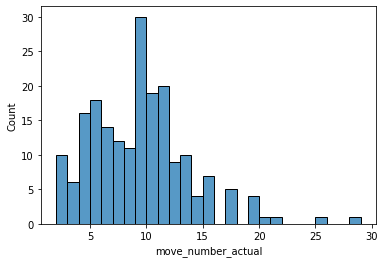

In [38]:
user_first_blnd_mist = first_blnd_mist.loc[first_blnd_mist['first_player_blunder'] == user]
user_first_blnd_mist[['game_date','score', 'blunder', 'mistake', 'move_number_actual','moves_list']].head()
sns.histplot(data=user_first_blnd_mist, x="move_number_actual", binwidth=1)

In [33]:
# get the average move number where the user makes their first mistake or blunder
num_games_week = (scored_games.groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                  ['game_link']
                  .agg(num_games = pd.Series.nunique))

user_first_blnd_mist_week = (user_first_blnd_mist.groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                             .agg(min_first_blnd_mist = ('move_number', 'min'),
                                 mean_first_blnd_mist = ('move_number', 'mean'),
                                 max_first_blnd_mist = ('move_number', 'max')))
#user_first_blnd_mist_week
user_first_blnd_mist_week = user_first_blnd_mist_week.join(num_games_week)

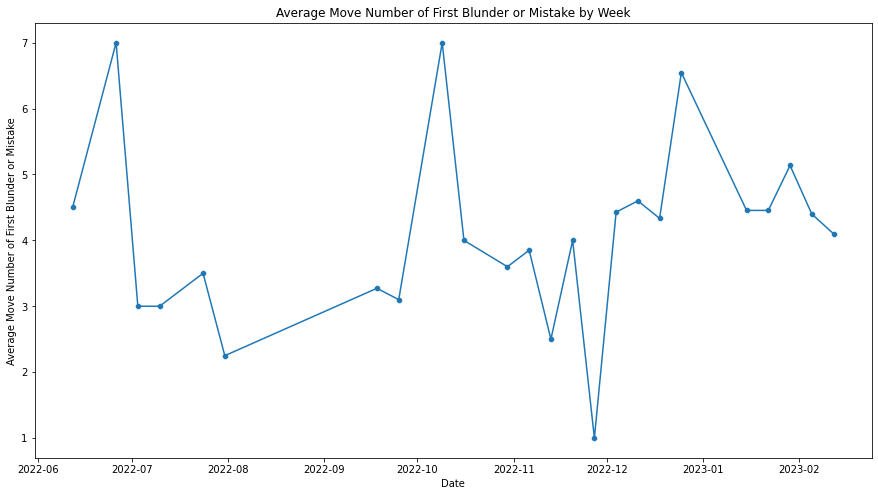

In [34]:
first_blnd = sns.scatterplot(data = user_first_blnd_mist_week, x = 'game_date', y = 'mean_first_blnd_mist')
first_blnd = sns.lineplot(data = user_first_blnd_mist_week, x = 'game_date', y = 'mean_first_blnd_mist')
first_blnd.set(xlabel = "Date",
               ylabel = "Average Move Number of First Blunder or Mistake",
               title = "Average Move Number of First Blunder or Mistake by Week")

plt.gcf().set_size_inches(15, 8)

In [35]:
# calculate the number of games played by week
num_games_week = (scored_games.groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                  ['game_link']
                  .agg(num_games = pd.Series.nunique))

# calculate the number of mistakes or blunders made by the user
# first filter by moves where the user of interest made the move and the move was either a blunder or a mistake
num_games_blnd_mist_week = (scored_games.loc[(scored_games['player_move'] == user) & ((scored_games['blunder']) | (scored_games['mistake']))]
                            # group by week
                            .groupby(pd.Grouper(key = 'game_date', freq = "1W"))
                            # select the blunder and mistake columns
                            [['blunder', 'mistake']]
                            # aggregate by
                            .agg({'blunder':'sum','mistake':'sum'}))
num_games_blnd_mist_week['blnd_mist'] = num_games_blnd_mist_week['blunder'] + num_games_blnd_mist_week['mistake']

weekly_blnd_mist_summary = num_games_blnd_mist_week.join(num_games_week)
weekly_blnd_mist_summary['blnd_mist_game_avg'] = weekly_blnd_mist_summary['blnd_mist'] / weekly_blnd_mist_summary['num_games']
weekly_blnd_mist_summary

,blunder,mistake,blnd_mist,num_games,blnd_mist_game_avg
game_date,,,,,
2022-06-12,9,11,20,4,5.000000
2022-06-19,4,5,9,1,9.000000
2022-06-26,14,13,27,2,13.500000
2022-07-03,65,46,111,10,11.100000
2022-07-10,41,42,83,10,8.300000
2022-07-17,0,0,0,0,NaN
2022-07-24,99,87,186,15,12.400000
2022-07-31,61,78,139,14,9.928571
2022-08-07,19,22,41,3,13.666667


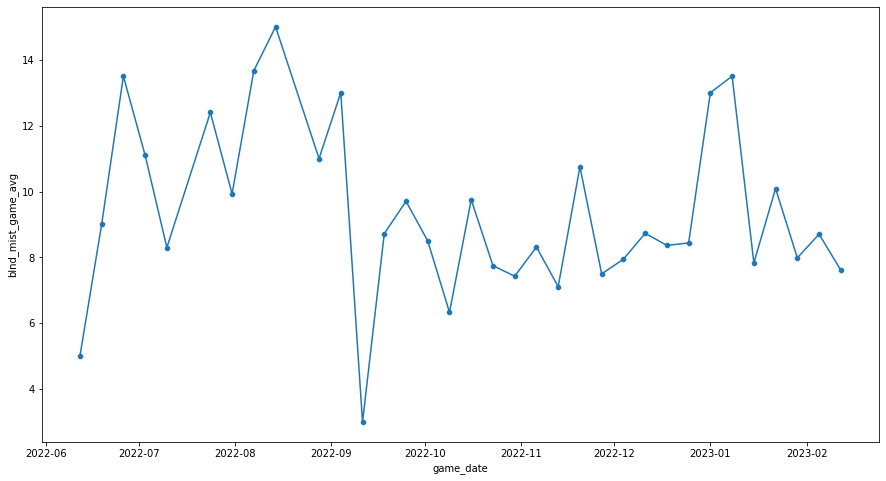

In [36]:
weekly_blnds = sns.scatterplot(data = weekly_blnd_mist_summary, x = 'game_date', y = 'blnd_mist_game_avg')
weekly_blnds = sns.lineplot(data = weekly_blnd_mist_summary, x = 'game_date', y = 'blnd_mist_game_avg')
#weekly_blnds = sns.lineplot(data = weekly_blnd_mist_summary, x = "game_date", y = 'blunder', color = "red")
#weekly_blnds = sns.lineplot(data = weekly_blnd_mist_summary, x = "game_date", y = 'mistake', color = "green")
#plt.plot(weekly_blnd_mist_summary.index, weekly_blnd_mist_summary['blnd_mist_game_avg'])

plt.gcf().set_size_inches(15, 8)

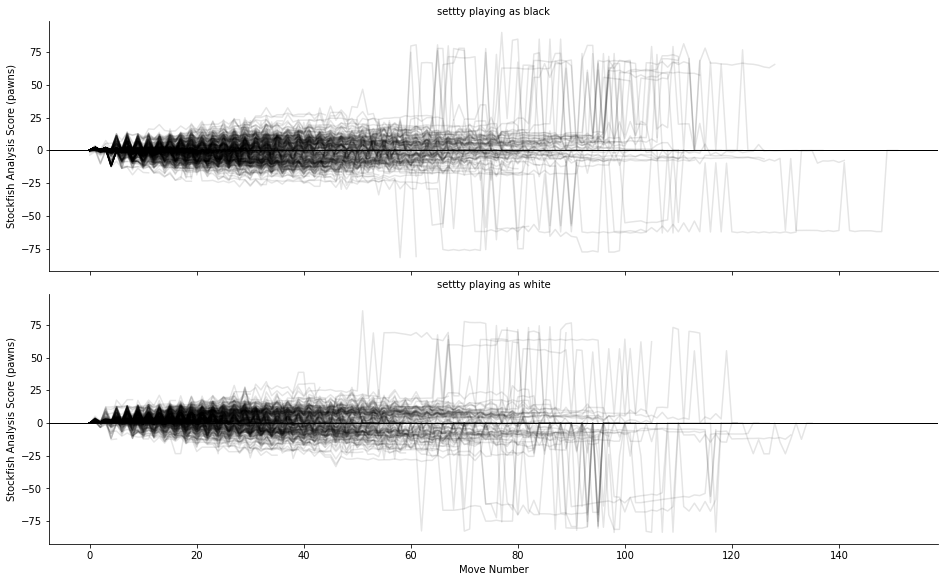

In [28]:
palette = sns.color_palette(['black'], len(scored_games['end_time'].unique()))

game_plot = sns.relplot(data = scored_games,
                        x = "move_number_actual",
                        y = "score",
                        hue='end_time',
                        row = "user_color",
                        kind="line",
                        alpha = 0.1,
                        palette=palette,
                        legend=False)

# set the x and y labels
game_plot.set(xlabel = "Move Number",
              ylabel = "Stockfish Analysis Score (pawns)")

# set the titles of both the charts to the user and color
game_plot.set_titles(user + ' playing as {row_name}')

# add horizontal black line at y = 0, to both plots
axes = game_plot.axes.flatten()
for ax in axes:
    ax.axhline(0, color = "black", linewidth = 1)
   
plt.gcf().set_size_inches(15, 8)

# code below fills above line
#game_plot.fill_between(first_game_copy['move_number_actual'],
#                      first_game_copy['score'], where = first_game_copy['score'] < 0,
#                      color="black", alpha = 0.3)